In [57]:
import os
import random

from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1
import numpy as np

import tensorflow as tf
from tensorflow import keras

import tensorflow_similarity as tfsim

tfsim.utils.tf_cap_memory()

print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity:", tfsim.__version__)


TensorFlow: 2.4.1
TensorFlow Similarity: 0.16.7


In [73]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255
)

train_generator = datagen.flow_from_directory(
    "../archive/deneme/train",
    shuffle=True,
    target_size=(224, 224),
)

valid_generator = datagen.flow_from_directory(
    "../archive/deneme/valid",
    shuffle=False,
    target_size=(224, 224),
)
x_train, y_train = train_generator.next()
x_test, y_test = next(valid_generator)

Found 4805 images belonging to 32 classes.
Found 160 images belonging to 32 classes.


array([[[[0.505882, 0.486275, 0.368627],
         [0.490196, 0.466667, 0.364706],
         [0.498039, 0.470588, 0.396078],
         [0.388235, 0.341176, 0.278431],
         ...,
         [0.4     , 0.32549 , 0.266667],
         [0.466667, 0.392157, 0.32549 ],
         [0.584314, 0.501961, 0.427451],
         [0.635294, 0.552941, 0.478431]],

        [[0.639216, 0.611765, 0.509804],
         [0.662745, 0.631373, 0.54902 ],
         [0.490196, 0.454902, 0.388235],
         [0.313726, 0.266667, 0.211765],
         ...,
         [0.470588, 0.407843, 0.34902 ],
         [0.509804, 0.443137, 0.380392],
         [0.6     , 0.533333, 0.462745],
         [0.658824, 0.592157, 0.521569]],

        [[0.709804, 0.678431, 0.603922],
         [0.564706, 0.529412, 0.462745],
         [0.337255, 0.290196, 0.235294],
         [0.360784, 0.305882, 0.262745],
         ...,
         [0.372549, 0.317647, 0.282353],
         [0.364706, 0.309804, 0.258824],
         [0.345098, 0.294118, 0.231373],
         [0

In [74]:
num_known_classes = 32
class_list = random.sample(population=range(32), k=num_known_classes)

classes_per_batch = 10
# Passing multiple examples per class per batch ensures that each example has
# multiple positive pairs. This can be useful when performing triplet mining or
# when using losses like `MultiSimilarityLoss` or `CircleLoss` as these can
# take a weighted mix of all the positive pairs. In general, more examples per
# class will lead to more information for the positive pairs, while more classes
# per batch will provide more varied information in the negative pairs. However,
# the losses compute the pairwise distance between the examples in a batch so
# the upper limit of the batch size is restricted by the memory.
examples_per_class_per_batch = 8

print(
    "Batch size is: "
    f"{min(classes_per_batch, num_known_classes) * examples_per_class_per_batch}"
)

print(" Create Training Data ".center(34, "#"))
train_ds = tfsim.samplers.MultiShotMemorySampler(
    x=x_train, y=train_generator.labels,
    classes_per_batch=classes_per_batch,
    steps_per_epoch=400,
    examples_per_class_per_batch=examples_per_class_per_batch,
    class_list=class_list
)

print("\n" + " Create Validation Data ".center(34, "#"))
val_ds = tfsim.samplers.MultiShotMemorySampler(
    x=x_test, y=valid_generator.labels,
    classes_per_batch=classes_per_batch,
)

Batch size is: 80
###### Create Training Data ######

The initial batch size is 80 (10 classes * 8 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/32 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/32 [00:00<?, ?it/s]

gather examples:   0%|          | 0/32 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/32 [00:00<?, ?it/s]


##### Create Validation Data #####

The initial batch size is 20 (10 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/32 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/32 [00:00<?, ?it/s]

gather examples:   0%|          | 0/32 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/32 [00:00<?, ?it/s]

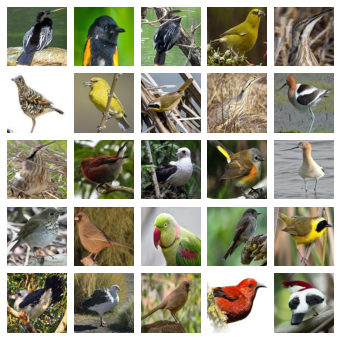

In [60]:
num_cols = num_rows = 5
# Get the first 25 examples.
x_slice, y_slice = train_ds.get_slice(begin=0, size=num_cols * num_rows)

fig = plt.figure(figsize=(6.0, 6.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

for ax, im, label in zip(grid, x_slice, y_slice):
    ax.imshow(im)
    ax.axis("off")

In [75]:
embedding_size = 256

inputs = keras.layers.Input((224, 224, 3))
x = keras.layers.Conv2D(64, 3, activation="relu")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D((4, 4))(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.GlobalMaxPool2D()(x)
outputs = tfsim.layers.MetricEmbedding(embedding_size)(x)

# building model
model = tfsim.models.SimilarityModel(inputs, outputs)
model.summary()

Model: "similarity_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
batch_normalization_12 (Batc (None, 222, 222, 64)      256       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 128)     73856     
_________________________________________________________________
batch_normalization_13 (Batc (None, 220, 220, 128)     512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 55, 55, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 53, 53, 256)

In [76]:
from keras.callbacks import ModelCheckpoint
import os

epochs = 5
learning_rate = 0.002
val_steps = 50

# init similarity loss
loss = tfsim.losses.MultiSimilarityLoss()

# compiling and training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate), loss=loss
)
pathdir = "../savedModels/"
checkpoint = ModelCheckpoint(filepath=os.path.join(pathdir),
                             save_best_only=True,
                             monitor="loss",
                             mode="max",
                             verbose=1
                             )
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, validation_steps=val_steps
    , callbacks=[checkpoint]
)

Distance metric automatically set to cosine use the distance arg to override.


IndexError: list index out of range